# Kickstarter Project

### Definition of relevant columns

* backers_count: amount of people pledging money to the project                                     
* category -> 'slug': name of the projects' specific parent- & sub-category (part of json string)
* country: country of the projects creator 
* creator -> 'id': id of the creator -> to be used as categorical variable (part of json string)
* goal: information on the amount of money needed to succeed in the local currency of the project
* launched_at: start date? of the project ()
* deadline: end date of the project ()
* spotlight: project highlighted on the website
* staff_pick: marked by a staff member of kickstarter (more attention drawn towards project)
* state: (successful/failed/canceled/live/suspended) -> exclude 'live' and combine 'canceled', 'suspended' with 'failed'
* static_usd_rate: exchange rate to transform goal in every column from current currency to USD



### Stakeholder: Project creator 
### Question: Is it useful to put much effort into launching a campaign on kickstarter? 
### Measure: Is the campaign likely to succeed or fail?

# KNN Classifire

## Import Libraries

In [25]:
import numpy as np
import pandas as pd
import seaborn as sns
from timeit import default_timer as timer
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier

In [3]:
# load the data 
df = pd.read_csv('data/cleaned_data.csv')

In [4]:
df.head()

,state,slug,launched_at_weekday,launched_at_month,duration_days,goal_in_usd,north_america
0,1,10,2,12,45,200.0,1
1,1,0,2,2,20,400.0,1
2,1,11,1,11,30,27224.0,1
3,1,5,5,10,41,45461.0,0
4,0,13,0,3,30,1000.0,1


In [5]:
df.shape

(201236, 7)

In [6]:
df.columns

Index(['state', 'slug', 'launched_at_weekday', 'launched_at_month',
       'duration_days', 'goal_in_usd', 'north_america'],
      dtype='object')

In [7]:
df['state'] = df['state'].astype('category')


In [8]:
df.dtypes

state                  category
slug                      int64
launched_at_weekday       int64
launched_at_month         int64
duration_days             int64
goal_in_usd             float64
north_america             int64
dtype: object

In [9]:
X = df.drop('state', axis=1)
y=df['state']

In [10]:
X

,slug,launched_at_weekday,launched_at_month,duration_days,goal_in_usd,north_america
0,10,2,12,45,200.0,1
1,0,2,2,20,400.0,1
2,11,1,11,30,27224.0,1
3,5,5,10,41,45461.0,0
4,13,0,3,30,1000.0,1
...,...,...,...,...,...,...
201231,7,1,2,44,10000.0,1
201232,7,5,12,30,5820.6,0
201233,5,4,8,30,8000.0,1
201234,12,1,2,29,1000.0,1


In [11]:
# Train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [12]:
# Train model
knn = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
knn.fit(X_train, np.ravel(y_train))

KNeighborsClassifier(metric='euclidean')

Accuracy: 0.63
Recall: 0.73
--------------------------------------------------


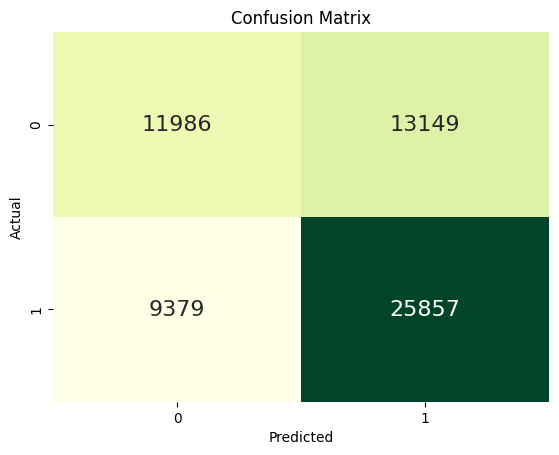

In [13]:
y_pred = knn.predict(X_test)

# Print accuracy score 
print("Accuracy:", accuracy_score(y_test, y_pred).round(2))
print("Recall:", recall_score(y_test, y_pred).round(2))
print("-----" * 10)

# Print confusion matrix with values
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='YlGn', cbar=False, annot_kws={"size": 16})

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


# Data Standardization 

In [14]:
# Before we have a look at the different methods, 
# we have to define which columns we want to scale.
col_scale = ['slug', 'launched_at_weekday', 'launched_at_month',
       'duration_days', 'goal_in_usd' , 'north_america']

In [15]:
# Scaling with standard scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[col_scale])
X_test_scaled = scaler.transform(X_test[col_scale])

In [16]:
# Concatenating scaled and dummy columns 
X_train_preprocessed = np.concatenate([X_train_scaled, X_train.drop(col_scale, axis=1)], axis=1)
X_test_preprocessed = np.concatenate([X_test_scaled, X_test.drop(col_scale, axis=1)], axis=1)

# MinMaxScaler

In [17]:
col_scale1 = ['slug', 'launched_at_weekday', 'launched_at_month',
       'duration_days', 'goal_in_usd']

In [18]:
# Scaling with MinMaxScaler
# Try to scale you data with the MinMaxScaler() from sklearn. 
# It follows the same syntax as the StandardScaler.
# Don't forget: you have to import the scaler at the top of your notebook. 

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train[col_scale1])
X_test_scaled = scaler.transform(X_test[col_scale1])


In [19]:
# Concatenating scaled and dummy columns 
X_train_preprocessed1 = np.concatenate([X_train_scaled, X_train.drop(col_scale1, axis=1)], axis=1)
X_test_preprocessed1 = np.concatenate([X_test_scaled, X_test.drop(col_scale1, axis=1)], axis=1)

### GridSearchCV

In [20]:
#what parameters does KNN have?
knn_classifier = KNeighborsClassifier()
knn_classifier.get_params().keys()

dict_keys(['algorithm', 'leaf_size', 'metric', 'metric_params', 'n_jobs', 'n_neighbors', 'p', 'weights'])

In [31]:
# Defining parameter grid (as dictionary)
param_grid = {"n_neighbors" : [3,5,7], #this actually defines the model you use
              "weights" : ["uniform", "distance"],
              "p" : [1, 2, 3],
              "algorithm": ["ball_tree", "kd_tree", "brute"]
             }

# Instantiate gridsearch and define the metric to optimize 
gs = GridSearchCV(KNeighborsClassifier(), param_grid, scoring='precision',
                  cv=5, verbose=3, n_jobs=-1)

# Fit gridsearch object to data.. also lets see how long it takes
start = timer()
gs.fit(X_train_preprocessed1, y_train)
end = timer()
gs_time = end-start

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[CV 1/5] END algorithm=ball_tree, n_neighbors=3, p=1, weights=distance;, score=0.682 total time=  16.9s
[CV 1/5] END algorithm=ball_tree, n_neighbors=3, p=1, weights=uniform;, score=0.670 total time=  17.3s
[CV 3/5] END algorithm=ball_tree, n_neighbors=3, p=1, weights=distance;, score=0.679 total time=  17.5s
[CV 2/5] END algorithm=ball_tree, n_neighbors=3, p=1, weights=distance;, score=0.677 total time=  18.0s
[CV 2/5] END algorithm=ball_tree, n_neighbors=3, p=1, weights=uniform;, score=0.668 total time=  18.5s
[CV 3/5] END algorithm=ball_tree, n_neighbors=3, p=1, weights=uniform;, score=0.666 total time=  18.8s
[CV 4/5] END algorithm=ball_tree, n_neighbors=3, p=1, weights=uniform;, score=0.664 total time=  18.8s
[CV 5/5] END algorithm=ball_tree, n_neighbors=3, p=1, weights=uniform;, score=0.673 total time=  19.0s
[CV 4/5] END algorithm=ball_tree, n_neighbors=3, p=1, weights=distance;, score=0.677 total time=  16.3s
[CV 1/5] END algorithm=ball_tree, n_neighbors=3, p=2, weights=uniform

KeyboardInterrupt: 

In [26]:
# Best score
print('Best score:', round(gs.best_score_, 3))
# Best parameters
print('Best parameters:', gs.best_params_)

Best score: 0.7
Best parameters: {'algorithm': 'brute', 'n_neighbors': 2, 'p': 3, 'weights': 'uniform'}


In [27]:
# we will do this at least twice.. according to DRY we should write a function
def print_pretty_summary(name, model, y_test, y_pred_test):
    print(name)
    print('=======================')
    print('n_neighbors: {}'.format(model.n_neighbors))
    print('weights: {}'.format(model.weights))
    print('p: {}'.format(model.p))
    print('algorithm: {}'.format(model.algorithm))

    precision = precision_score(y_test, y_pred_test)
    print('Test precision: {:2f}'.format(precision))
    return precision

In [28]:
# Assigning the fitted KNNClassifier model with best parameter combination to a new variable knn_best
knn_best = gs.best_estimator_

# Making predictions on the test set
y_pred_test = knn_best.predict(X_test_preprocessed1)
# Let us print out the performance of our model on the test set.
knn_precision = print_pretty_summary('KNNClassifier model', knn_best, y_test, y_pred_test)

KNNClassifier model
n_neighbors: 2
weights: uniform
p: 3
algorithm: brute
Test precision: 0.707415


Accuracy: 0.59
Recall: 0.49
--------------------------------------------------


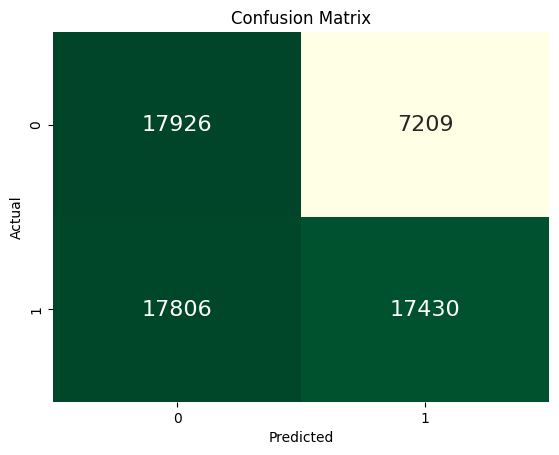

In [30]:
# Print accuracy score 
print("Accuracy:", accuracy_score(y_test, y_pred_test).round(2))
print("Recall:", recall_score(y_test, y_pred_test).round(2))
print("-----" * 10)

# Print confusion matrix with values
conf_matrix = confusion_matrix(y_test, y_pred_test)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='YlGn', cbar=False, annot_kws={"size": 16})

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
